# Recurrent Neural Networks 

*History doesn’t repeat itself, but it often rhymes* - Mark Twain

We analyze the application of **Recurrent Neural Networks (RNNs)** for forecasting multivariate time series data, focusing on U.S. Consumer Price Index (CPI) components. RNN models are trained under different configurations to compare their predictive performance and investigate the behavior of their hidden states. Additionally, we examine how the temporal patterns learned by RNNs relate to the latent factors uncovered by Dynamic Factor Models (DFMs), a classical econometric approach for modeling co-movements in time series data.

In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import gc
import statsmodels.api as sm
import torch
import torch.nn as nn
import torchinfo
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from finds.structured import BusDay
from finds.readers import Alfred
from secret import credentials
import warnings

In [2]:
# %matplotlib qt
VERBOSE = 0
if not VERBOSE:  # Suppress FutureWarning messages
    warnings.simplefilter(action='ignore', category=FutureWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train-test split date
split_date = '2021-12-01'

## Sequence modeling

**Recurrent Neural Networks (RNNs)** are powerful models for learning from sequential data, enabling tasks such as language modeling, translation, and time series forecasting by maintaining a memory of past inpformation. Unlike feedforward networks, RNNs process sequences one step at a time, using a hidden state that carries information across time steps to capture temporal dependencies. Variants like Elman and Jordan networks provide basic feedback mechanisms, while more advanced models such as LSTMs and GRUs address training challenges like vanishing gradients. However, RNNs remain inherently sequential, making them slower to train and less parallelizable compared to modern architectures like convolutional or transformer models.



### Recurrent units


RNNs retain temporal information through recurrent connections, applying the same computation repeatedly at each time step while maintaining a **hidden state (memory)**. The hidden state $h_t$ is updated based on the current input $x_t$ and the previous hidden state $h_{t-1}$:

$$
h_t = f_h(x_t, h_{t-1}, \theta_h)
$$

$$
h_t = f_h(x_t, h_{t-1}, \theta_h)
$$

where the initial hidden state $h_0$ is typically initialized to zero, $\theta_h$ are learnable parameters, and $f_h$ is the recurrent function (e.g., tanh, ReLU, GRU, LSTM).

Training RNNs is more complex than training feedforward neural networks due to dependencies across time steps. 

RNNs are unfolded through time, applying the same parameters (shared weights) at each step, and trained using standard backpropogation, known as **Backpropagation Through Time (BPTT)** when applied over multiple time steps.
This makes training computationally expensive, and prone to **vanishing gradients** (gradients shrink) and **exploding gradients** (gradients blow up), which respectively limit the model's ability to learn long-range dependencies and cause unstable updates.

### LSTM networks

**Long Short-Term Memory (LSTM)** networks mitigate the vanishing gradient problem by introducing a **cell state** and multiple **gating mechanisms** that regulate information flow. Key components include:

- Cell state $c_t$: A "memory" that runs through the network, modified by gates.
- Hidden state $h_t$: Output of the LSTM at each time step.
- Input $x_t$: Current input at time $t$.
- Previous state $h_{t-1}, c_{t-1}$: From the last time step.
- Gates:
  - Forget gate $f_t$: Decides what information to discard from the cell state.
  - Input gate $i_t$: Controls how much new information flows into the cell state.
  - Output gate $o_t$: Determines what part of the cell state should be output as $h_t$.

A cell update combines the past cell state and new input to update $c_t$. The $h_t$ output is updated from $c_t$ and previous its previous state $h_{t-1}$.


### GRU networks

**Gated Recurrent Unit (GRU)** networks are a simplified version of LSTMs that combine cell state and hidden state into a single vector, using fewer gates:

- Update gate (similar to combined forget/input gate): Controls what part of the past state to keep.
- Reset gate: Controls how to combine new input with the previous memory.
- Single hidden state $h_t$: Serves as both memory and output.

GRUs are computationally more efficient than LSTM, and perform comparably on many tasks.

## Elman network

An **Elman network** is a basic RNN where recurrence occurs within the hidden layer:

$$h_t = f(x_t, h_{t-1})$$

Multiple Elman layers can be stacked to capture longer-term dependencies and more complex temporal patterns.
For every element in the input sequence, each layer computes the following function:

$$h_t = \tanh(x_t~W_{ih}^T​ + b_{ih} ​+ h_{t−1} ​W_{hh}^T ​+ b _{hh}​)$$

where 

- $h_t$​ is the hidden state at time $t$, 
- $x_t$​ is the input at time $t$,
- $h_{t−1}$​ is the hidden state of the previous layer at time $t-1$ or the initial hidden state at time 0, and
- $b$'s and $W$'s are the learnable bias and weights

We implement a single-layer Elman RNN using PyTorch's standard `RNN` module to process sequential data, with `Dropout` regularization to reduce overfitting. 

In [3]:
class Elman(nn.Module):
    def __init__(self, n_features, hidden_size, dropout, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = n_features
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.RNN(input_size=n_features,
                          hidden_size=hidden_size,
                          num_layers=num_layers)
        self.o2o = nn.Linear(hidden_size, n_features)

    def forward(self, x, hidden):
        x = self.dropout(x)     # drop out input layer
        output, hidden = self.rnn(x, hidden)
        output = self.o2o(output[-1:, :])
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.num_layers, self.hidden_size)

### Data preparation

CPI time series data for multiple components (e.g., food, housing) are collected from FRED. The data are log-transformed and differenced to ensure stationarity, then standardized (using `StandardScaler`) to have mean 0 and variance 1. The time series data are split into training followed by testing sets using a defined cutoff date.



In [4]:
# Max number of hidden states (RNN) or factors (Dynamic Model)
K = 2

In [5]:
# number of out-of-sample forecasts to predict
nforecast = 3

In [7]:
# Load time series from FRED
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)
vspans = alf.date_spans('USREC')  # recession periods

In [8]:
# CPI for U.S. City Average: Monthly, Seasonally Adjusted
# https://fred.stlouisfed.org/release/tables?rid=10&eid=34483
# 'CUSR0000SEEA'
series_ids = ['CPIFABSL', 'CPIHOSSL', 'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CPIOGSSL']
df = pd.concat([alf(s, log=1, diff=1) for s in series_ids], axis=1)\
       .dropna()\
       .sort_index()
df.index = BusDay.to_datetime(df.index)
df.index.freq = 'ME'     # set index to datetime type and freq = 'M'

In [9]:
names = [s[s.find(':')+2:s.find(' in ')] for s in alf.header(series_ids)]
names

['Food and Beverages',
 'Housing',
 'Apparel',
 'Transportation',
 'Medical Care',
 'Other Goods and Services']

In [10]:
# Standardize the data data
scaler = StandardScaler().fit(df)
scaled_data = DataFrame(scaler.transform(df), columns=names, index=df.index)
scaled_data

,Food and Beverages,Housing,Apparel,Transportation,Medical Care,Other Goods and Services
date,,,,,,
1967-02-28,-1.520716,-1.129800,0.533990,0.266586,-0.248585,-1.017195
1967-03-31,-0.805655,-1.129800,0.124553,-0.267488,-0.253160,-0.284868
1967-04-30,-1.522780,-0.063784,0.529140,0.263339,0.988995,-1.017195
1967-05-31,-0.805655,-0.067262,0.122142,-0.003280,-0.266687,-0.286982
1967-06-30,1.339539,-1.129800,0.524347,-0.267488,0.962232,-0.289083
...,...,...,...,...,...,...
2024-10-31,-0.252031,0.063171,-2.110286,-0.203592,-0.692758,-0.172972
2024-11-30,-0.053379,-0.037266,-0.114479,0.027062,-0.702581,0.085335
2024-12-31,-0.180743,-0.209529,-0.015224,0.767819,-1.058184,-1.113129


In [11]:
# Create input data for RNN
ntrain = sum(scaled_data.index < split_date)
ntest = len(scaled_data.index) - ntrain - 1
n_features = scaled_data.shape[1]
data = scaled_data.values

### Training

RNN models with different hidden sizes ($K = 1, 2$) are trained using an Adam optimizer and a `StepLR` learning rate scheduler, which reduces the learning rate during training for better convergence.


In [12]:
# Train model
num_layers = 1
dropout = 0.0
lr = 0.01         # starting learning rate
step_size = 100   # number of steps per learning rate
num_lr = 3        # number of learning rate periods
num_epochs = step_size * num_lr

train_loss = {}
hidden_states = {}
for hidden_size in range(1, K+1):
    torch.manual_seed(0)
    model = Elman(n_features=n_features,
                  hidden_size=hidden_size,
                  dropout=dropout,
                  num_layers=num_layers).to(device)
    print(model)
    torchinfo.summary(model)

    # Set optimizer and learning rate scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=step_size,
                                                gamma=0.1)
    loss_function = nn.MSELoss()
    train_loss[hidden_size] = []
    for epoch in tqdm(range(num_epochs)):   # Run training loop per epoch
        model.train()
        model.zero_grad()
        hidden = model.init_hidden().to(device)
        loss = torch.FloatTensor([0]).to(device)
        for i in range(ntrain):
            x = torch.FloatTensor(data[[i], :]).to(device)
            y = torch.FloatTensor(data[[i+1], :]).to(device)
            output, hidden = model(x, hidden)
            l = loss_function(output, y)
            loss += l
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        model.eval()
        train_loss[hidden_size].append(float(loss)/ntrain)
        #if VERBOSE:
        #    print(epoch, train_loss[hidden_size][-1], scheduler.get_last_lr())

    # collect predictions and hidden states, and compute mse
    with torch.no_grad():    # reduce memory consumption for eval
        loss_function = nn.MSELoss()
        hidden = model.init_hidden().to(device)
        hidden_states[hidden_size] = [hidden.cpu().numpy().flatten()]
        y_pred = [np.zeros(n_features)]
        for i in range(ntrain + ntest):
            x = torch.FloatTensor(data[[i], :]).to(device)
            y = torch.FloatTensor(data[[i+1], :]).to(device)
            output, hidden = model(x, hidden)
            hidden_states[hidden_size].append(hidden.cpu().numpy().flatten())
            y_pred.append(output.cpu().numpy().flatten())

        # k-step ahead forecast at end of period
        for i in range(nforecast):
            x = y
            y, hidden = model(x, hidden)
            y_pred.append(y.cpu().numpy().flatten())
        print(f"train MSE (hidden={hidden_size}):",
              mean_squared_error(data[1:ntrain+1, :], y_pred[1:ntrain+1]))
        print(f"test MSE (hidden={hidden_size}):",
              mean_squared_error(data[ntrain+1:ntrain+ntest+1, :],
                                 y_pred[ntrain+1:ntrain+ntest+1]))



Elman(
  (dropout): Dropout(p=0.0, inplace=False)
  (rnn): RNN(6, 1)
  (o2o): Linear(in_features=1, out_features=6, bias=True)
)


100%|██████████| 300/300 [01:42<00:00,  2.93it/s]


train MSE (hidden=1): 0.8150888820868842
test MSE (hidden=1): 0.7845472493024133
Elman(
  (dropout): Dropout(p=0.0, inplace=False)
  (rnn): RNN(6, 2)
  (o2o): Linear(in_features=2, out_features=6, bias=True)
)


100%|██████████| 300/300 [01:38<00:00,  3.04it/s]

train MSE (hidden=2): 0.757587880335504
test MSE (hidden=2): 0.7211778265327311


### Evaluation

The training and testing MSE for each RNN model are calculated for performance comparison. Training loss curves across epochs are plotted to assess convergence, and out-of-sample forecasts for 3 time steps ahead, after the end of the sample period, are visualized.

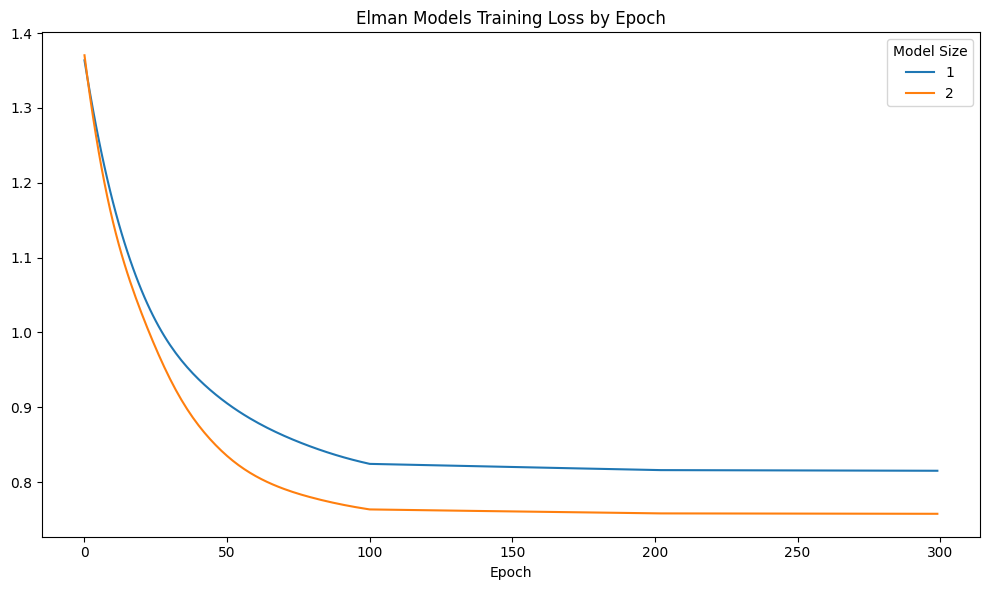

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
DataFrame(train_loss).plot(ax=ax)
ax.set_title(f"Elman Models Training Loss by Epoch")
ax.set_xlabel('Epoch')
ax.legend(title='Model Size')
plt.tight_layout()

In [14]:
# Show forecasts of last model
pred = scaler.inverse_transform(y_pred)      # undo standardization
t = [scaled_data.index[-1] + pd.DateOffset(months=i) for i in range(nforecast + 1)]
forecasts = DataFrame(np.vstack((np.zeros(n_features), pred[-nforecast:])),
                      index=pd.PeriodIndex(t, freq='M'), columns=scaled_data.columns)
print("Monthly forecasts from RNN Model")
forecasts

Monthly forecasts from RNN Model


,Food and Beverages,Housing,Apparel,Transportation,Medical Care,Other Goods and Services
2025-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-03,0.002727,0.002439,0.000359,0.001873,0.003255,0.003144
2025-04,0.002429,0.002219,0.000304,0.001803,0.003247,0.003125
2025-05,0.002214,0.002026,0.000220,0.001723,0.003180,0.003065


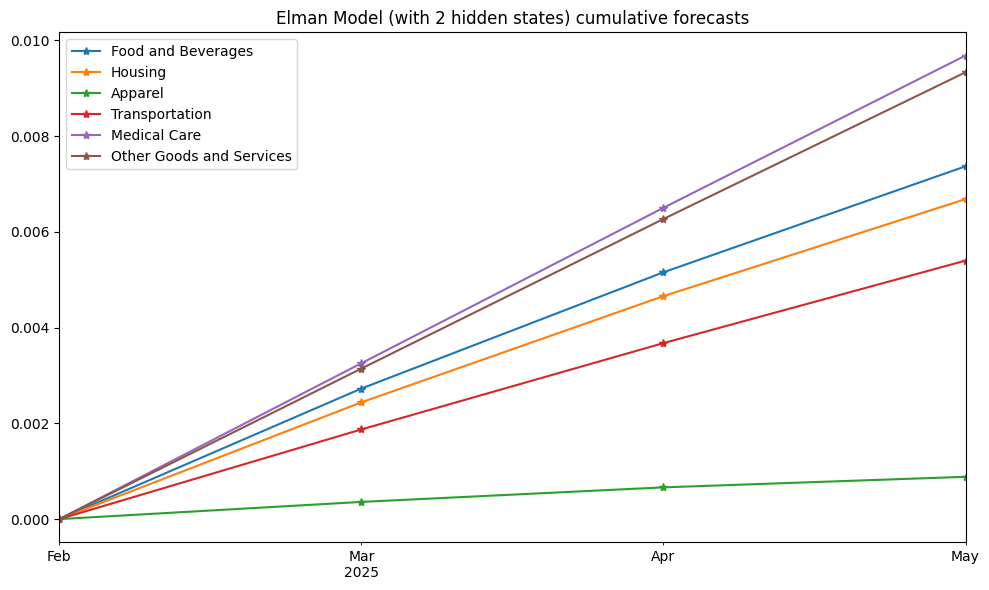

In [15]:
# Plot forecasts
fig, ax = plt.subplots(figsize=(10, 6))
forecasts.cumsum().plot(ax=ax, marker='*')
ax.set_title(f"Elman Model (with {K} hidden states) cumulative forecasts")
plt.tight_layout()


### Hidden states

Hidden states from the last training epoch are collected, and their cumulative sums are plotted to illustrate how the internal memory of the Elman RNN evolves over time.


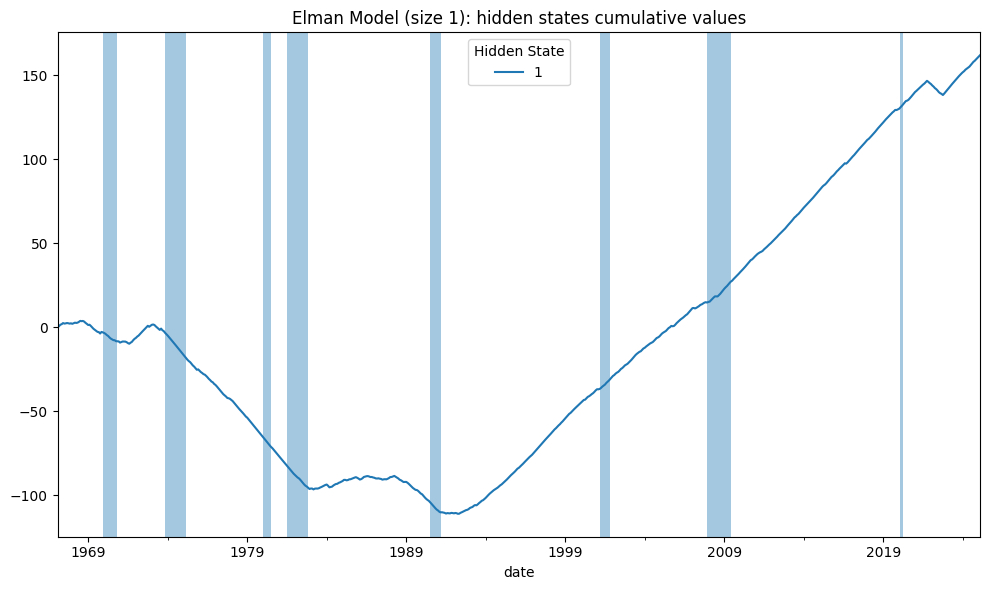

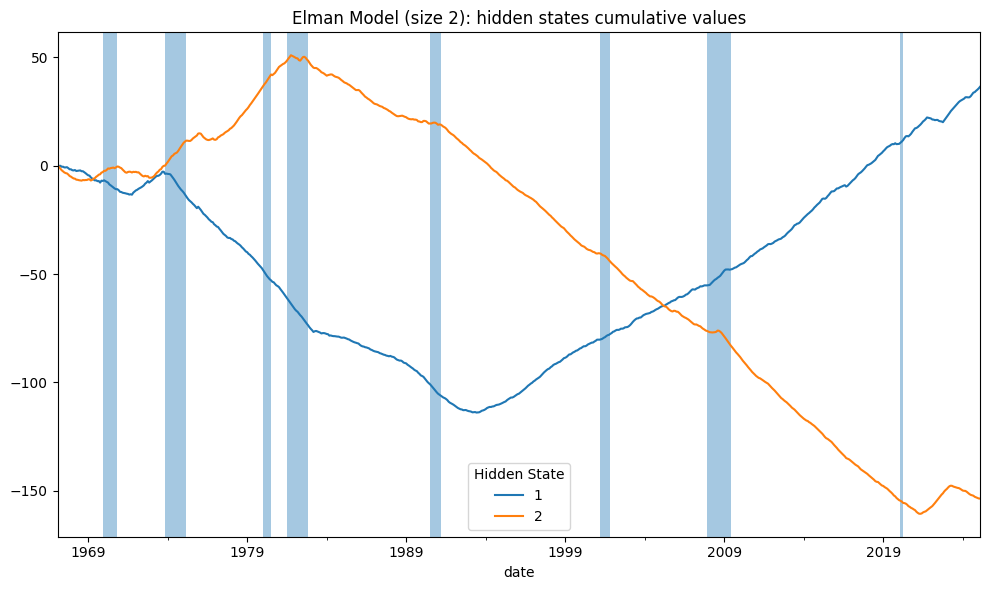

In [16]:

# Plot RNN hidden states values
for k, hidden in hidden_states.items():
    fig, ax = plt.subplots(figsize=(10, 6))
    hidden = DataFrame(np.array(hidden), index=scaled_data.index,
                       columns=[f"{i+1}" for i in range(k)])
    hidden.cumsum().plot(ax=ax, style='-')
    for a,b in vspans:
        if a >= min(hidden.index):
            ax.axvspan(a, min(b, max(hidden.index)), alpha=0.4)
    ax.legend(title='Hidden State')
    ax.set_title(f"Elman Model (size {k}): hidden states cumulative values")
    plt.tight_layout()


## Dynamic Factor Models

This statistical model captures co-movements in time series using latent factors:

The basic model is:

$$y_t = \Lambda f_t + \epsilon_t$$

$$f_t = A_1 f_{t-1} + \cdots + A_2 f_{t-2} + u_t$$

where:
- $y_t$ is observed data at time t
- $\epsilon_t$ is idiosyncratic disturbance at time t
- $f_t$ is the unobserved factor at time t
- $u_t \sim N(0, Q)$ is the factor disturbance at time t
- $\Lambda$ is referred to as the matrix of factor loadings
- $A_i$ are matrices of autoregression coefficients

We use `DynamicFactorMQ` from `statsmodels`, which employs an **Expectation-Maximization (EM)** algorithm for fitting, and so can accommodate a large number of observed variables. This can handle
any collection of blocks of factors, including different factor autoregression orders, and AR(1) processes for
idiosyncratic disturbances. The model allows incorporate monthly/quarterly mixed
frequency data, making it suitable for **nowcasting**.

- https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_dfm_coincident.html



We fit models with varying lag orders (p) to find an optimal autoregressive structure.


In [17]:

# Fit ar lags with best BIC
dynamic_factors = dict()
models = {}
K = 2
for ar in range(1, 5):
    mod = sm.tsa.DynamicFactorMQ(endog=scaled_data,
                                 factors=1,                # num factor blocks
                                 factor_multiplicities=K,  # num factors in block
                                 factor_orders=ar,         # order of factor VAR
                                 idiosyncratic_ar1=True)
    fitted = mod.fit(disp=20 * bool(VERBOSE),
                     maxiter=1000,
                     full_output=True)
    models[ar] = dict(bic=fitted.bic, 
                      mse=fitted.mse, 
                      summary=fitted.summary().tables[0],
                      predict=fitted.predict(),
                      forecast=fitted.forecast(nforecast),
                      params=len(fitted.param_names))
    dynamic_factors[ar] = DataFrame(fitted.factors.filtered)
    dynamic_factors[ar].columns = np.arange(1, K+1)
    print(DataFrame(dict(bic=fitted.bic,
                         mse=fitted.mse,
                         parameters=len(fitted.param_names)),
                    index=[ar]))
    del fitted
    del mod
    gc.collect()



            bic       mse  parameters
1  10478.491794  4.275815          31
            bic       mse  parameters
2  10499.374971  4.272672          35
            bic       mse  parameters
3  10506.462669  4.243688          39
            bic       mse  parameters
4  10517.472768  4.231597          43


### Lag order

Bayesian Information Criterion (BIC) is used to select the optimal lag order

In [18]:
# dynamic model with best bic
best, model = min(models.items(), key=lambda item: item[1]['bic'])
mse = mean_squared_error(scaled_data, model['predict'])
print('Best lag:', best, '  bic:', model['bic'])
print(model['summary'])


Best lag: 1   bic: 10478.49179401509
                                   Dynamic Factor Results                                   
Dep. Variable:     "Food and Beverages", and 5 more   No. Observations:                  697
Model:                         Dynamic Factor Model   Log Likelihood               -5137.771
                            + 2 factors in 1 blocks   AIC                          10337.541
                              + AR(1) idiosyncratic   BIC                          10478.492
Date:                              Sat, 15 Mar 2025   HQIC                         10392.038
Time:                                      05:18:21   EM Iterations                      182
Sample:                                  02-28-1967                                         
                                       - 02-28-2025                                         
Covariance Type:                       Not computed                                         


### Evaluation

The models are evaluated based on **train/test MSE**. The 3-step-ahead forecasts, as of the end of the sample period, are also plotted.
 

In [19]:
# Show prediction errors
print('Dynamic Factor Model Train MSE:', 
      mean_squared_error(scaled_data.iloc[1:ntrain+1],
                         model['predict'].iloc[1:ntrain+1]))
print('Dynamic Factor Model Test MSE:', 
      mean_squared_error(scaled_data.iloc[ntrain+1:],
                         model['predict'].iloc[ntrain+1:]))
print('Number of parameters:', model['params'])


Dynamic Factor Model Train MSE: 0.7131933696697343
Dynamic Factor Model Test MSE: 0.7405157478690289
Number of parameters: 31


In [20]:
model_out = scaler.inverse_transform(model['forecast'].iloc[:nforecast])
model_out = DataFrame(np.vstack((np.zeros(n_features), model_out)),
                      index=pd.PeriodIndex(t, freq='M'), columns=scaled_data.columns)
print("Monthly forecasts from Dynamic Factor Model")
model_out


Monthly forecasts from Dynamic Factor Model


,Food and Beverages,Housing,Apparel,Transportation,Medical Care,Other Goods and Services
2025-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-03,0.002508,0.002980,0.001488,0.000141,0.002883,0.002253
2025-04,0.002666,0.002714,0.000947,0.001794,0.002942,0.002512
2025-05,0.002714,0.002649,0.000894,0.002477,0.002987,0.002546


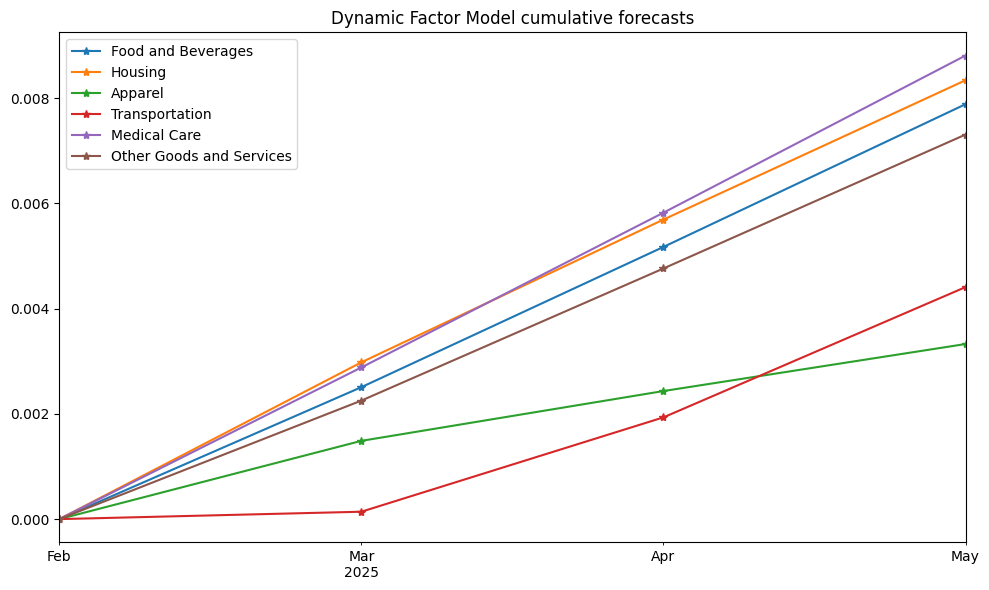

In [21]:
# Plot forecasts
fig, ax = plt.subplots(figsize=(10, 6))
model_out.cumsum().plot(ax=ax, marker='*')
ax.set_title(f"Dynamic Factor Model cumulative forecasts")
plt.tight_layout()

### Dynamic factors

Dynamic factors represent unobserved common drivers of the time series, and their cumulative sums highlight underlying trends or cycles. In macroeconomic datasets, these latent factors often correspond to broad economic forces or business cycles. These cumulative factors are plotted to visualize their temporal patterns.  


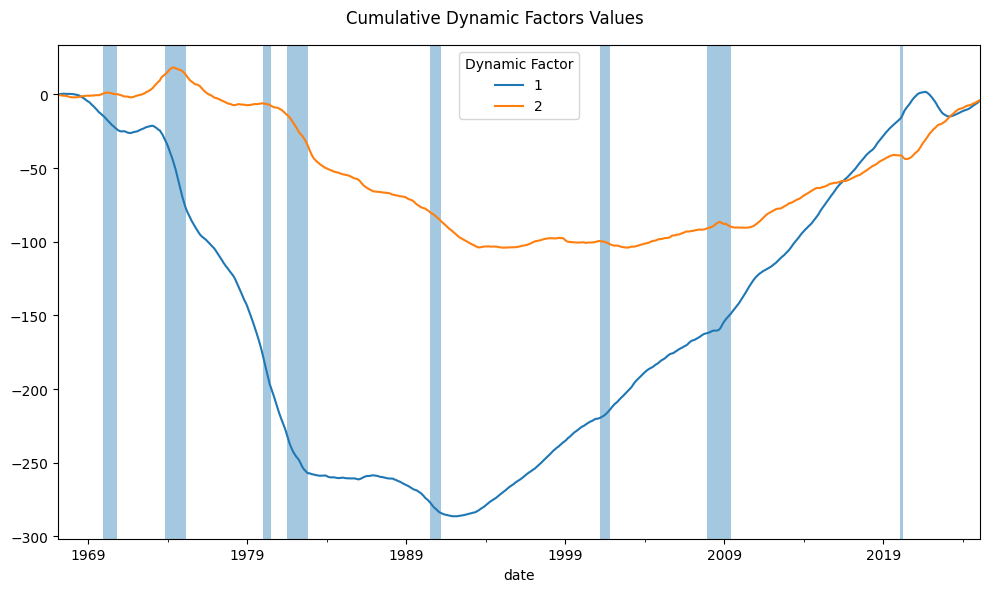

In [22]:
# Plot dynamic factors
dynamic_factor = dynamic_factors[best]
fig, ax = plt.subplots(figsize=(10, 6))
dynamic_factor.cumsum().plot(ax=ax, style='-')
ax.legend(title='Dynamic Factor')
for a,b in vspans:
    if a >= min(dynamic_factor.index):
        ax.axvspan(a, min(b, max(dynamic_factor.index)), alpha=0.4)
plt.suptitle(f"Cumulative Dynamic Factors Values")
plt.tight_layout()

The hidden states from the simple Elman RNN are compared to DFM latent factors, and with R-squared (R²) statistics reported to measure the degree of overlap.


In [23]:
# RNN hidden state values explained by dynamic factors
rsq = dict()
for k, hidden_state in enumerate(np.array(hidden_states[2]).T):
    rsq[k+1] = sm.OLS(hidden_state, sm.add_constant(dynamic_factor).fillna(0))\
                 .fit()
print('Proportion of variance of RNN hidden state values '
      'explained by dynamic factors:',
      np.mean([r.rsquared for r in rsq.values()]).round(4))
DataFrame({k: [r.rsquared, r.f_pvalue] for k, r in rsq.items()},
          index=['R-square', 'pvalue'])\
          .rename_axis(columns='Hidden State')\
          .round(4)

Proportion of variance of RNN hidden state values explained by dynamic factors: 0.7471


Hidden State,1,2
R-square,0.7494,0.7447
pvalue,0.0000,0.0000


**References:**

Philipp Krähenbühl, 2020-2024, "AI394T Deep Learning course materials", retrieved from
https://www.philkr.net/dl_class/material
